Before we begin, let's retrieve some audio files of songs. The best file to work with in Python is .mav. In the genres_original folder we can find some test data for our algorithm.

In [1]:
# if you have .mp3 file you can use this code to convert it into .mav
# ls *.mp3 | rg -o "(.*?)\.mp3" -r '$1' | xargs -n 1 -I '{}' -d '\n' ffmpeg -i '{}.mp3' -ac 1 'converted/{}.wav

### Create Fingerprints

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set default display parameters
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 140

import scipy
from scipy import fft, signal
from scipy.io.wavfile import read

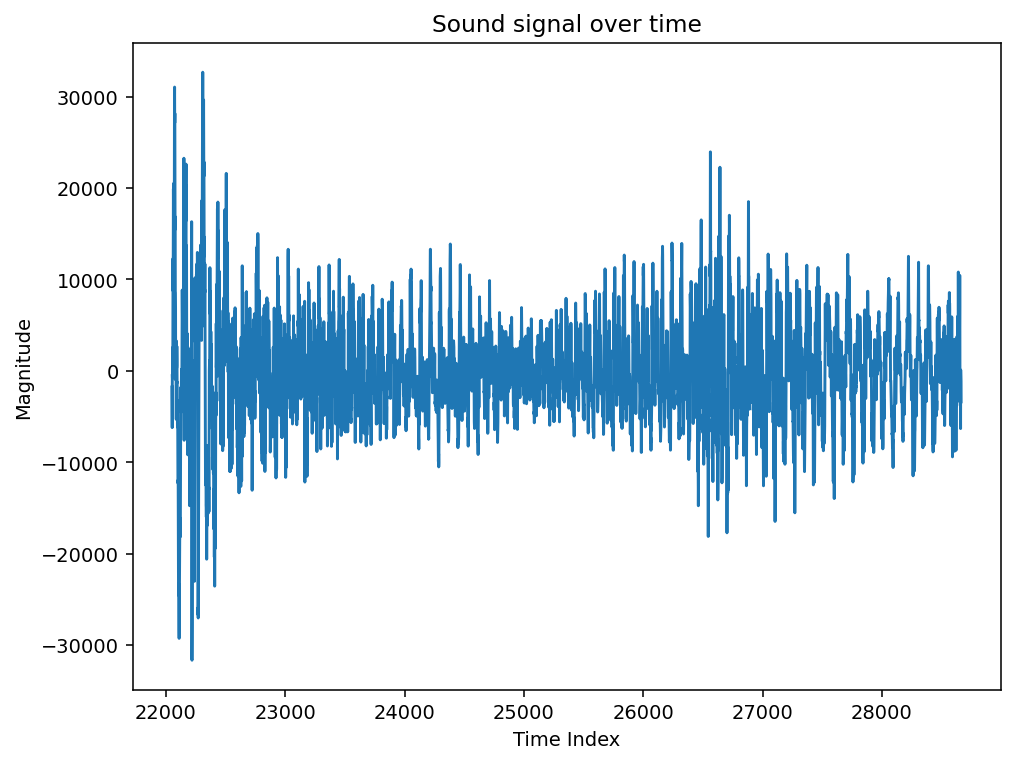

In [8]:
# Read .wav files
Fs, song = read("genres_original/hiphop/hiphop.00004.wav") # --> insert file .mav here
time_to_plot = np.arange(Fs * 1, Fs * 1.3, dtype=int) # --> It starts at Fs * 1 (1 second) and ends at Fs * 1.3 (1.3 seconds)

# plot signal against time in seconds.
plt.plot(time_to_plot, song[time_to_plot])
plt.title('Sound signal over time')
plt.xlabel('Time Index')
plt.ylabel('Magnitude')
plt.show()

Problems with this graph:
1. There is a lot of high frequency noise --> difficult to identify peaks
2. Any background noise will be indistinguishable from the main song

### Fourier Analysis

Fourier analysis breaks down complex audio signals into their frequency components, essential for visualizing and extracting features like dominant frequencies and rhythmic patterns. This information enables comparing tracks, aiding in music recognition algorithms.

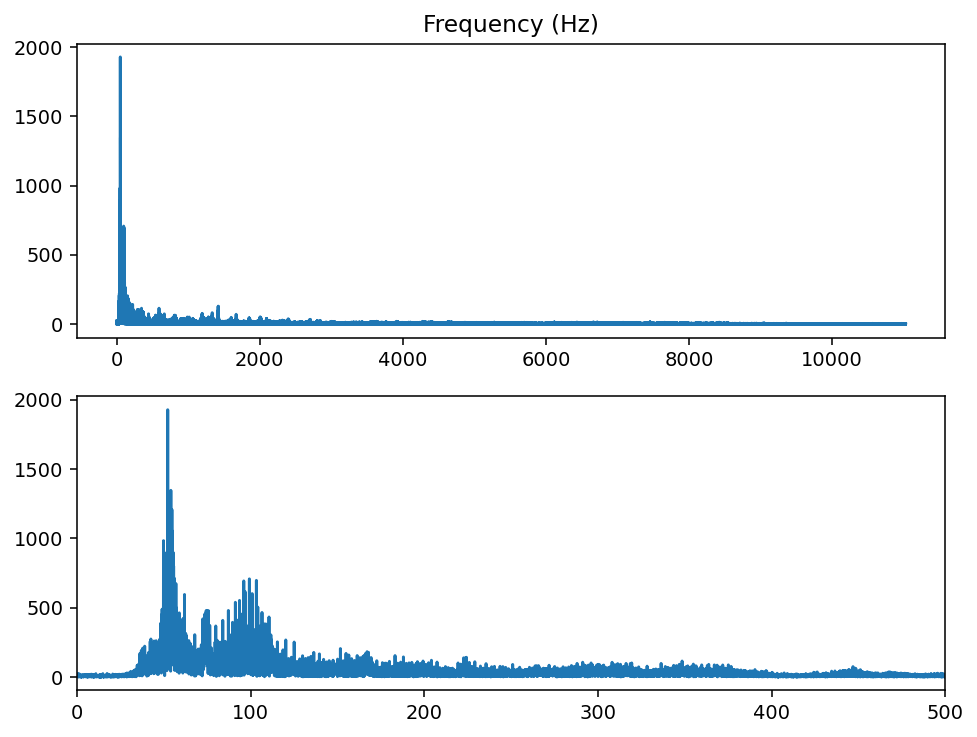

In [17]:
# Fast Fourier Transform (FFT) to analyze the frequency content of the audio signal
from scipy.fft import fftfreq

N = len(song)
fft = scipy.fft.fft(song) # complex-valued array representing the frequency domain

# magnitude of the FFT output (the amplitude spectrum) up to the Nyquist frequency (half of the sampling frequency) --> Normalization
transform_y = 2.0 / N * np.abs(fft[0:N//2])
# Generates the frequency values corresponding to the FFT
transform_x = scipy.fft.fftfreq(N, 1/Fs)[:N//2] 

# Plot
plt.subplot(2, 1, 1)
plt.title('Frequency (Hz)')
plt.plot(transform_x, transform_y)

plt.subplot(2,1,2)
plt.plot(transform_x, transform_y)
plt.xlim(0, 500)

plt.show()

###  find peaks in the spectrum

music tends to have it's strongest peaks in the lower frequency range (< 500Hz), so a peak finding method that only considers the most prominent peaks (peaks with the shallowest 'valley' on either side) will have it's peaks concentrated in the bass frequencies. 

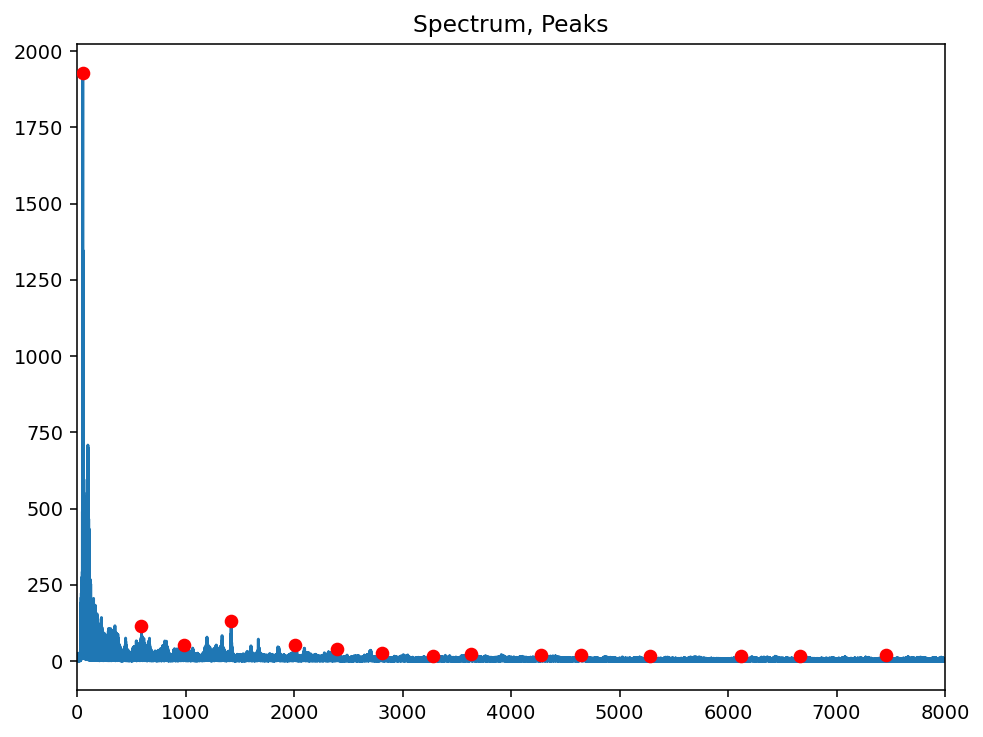

In [23]:
all_peaks, props = signal.find_peaks(transform_y)  # detects all peaks in the transform_y. The function returns the indices of all peaks found (all_peaks) and properties of the detected peaks (props).
peaks, props = signal.find_peaks(transform_y, prominence=0, distance=10000) # prominence parameter sets a minimum prominence of peaks, distance parameter specifies the minimum horizontal distance between adjacent peaks.
n_peaks = 15 # --> try to modify and see how peaks change

# Get the n_peaks largest peaks from the prominences
# This is an argpartition
largest_peaks_indices = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
largest_peaks = peaks[largest_peaks_indices] # indices of the largest peaks from the peaks

plt.plot(transform_x, transform_y, label="Spectrum")
plt.title('Spectrum, Peaks')
plt.scatter(transform_x[largest_peaks], transform_y[largest_peaks], color="r", zorder=10, label="Constrained Peaks")
plt.xlim(0, 8000)

plt.show()

Peak frequencies extracted through Fourier analysis offer a succinct representation of the analyzed sound. However, scrutinizing the entire song at once risks overlooking nuances in sound, such as variations between the chorus and final verse. Additionally, brief audio snippets, like those captured on a user's phone, may inadequately capture the full frequency spectrum of the song.

To surmount this challenge, the Short Time Fourier Transform (STFT) from SciPy presents a solution. This method dissects the song into brief segments, typically lasting half a second, and applies Fourier Transform to each segment independently. By identifying prominent frequencies within each snippet, we capture the dynamic evolution of the song's frequency composition over time. Consequently, irrespective of the portion sampled, we can match it to its corresponding snippet, enhancing the accuracy of recognition. The STFT accomplishes this by applying the Fourier Transform in windows with slight overlap between consecutive segments, enabling a comprehensive analysis of temporal variations in frequency content.